# Problem 4.1
Attributions: Shashank, with discussions with Elena.
# Part a

We start by importing our numerical workhorses.

In [69]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

For part a, we were asked to look in to the data generated pertaining to the neural circuitry experiments performed in *C.elegans* using optogenetics. The probability of a reversal event was binomially distributed:
\begin{align}
P(p \mid n_r, n, I) = \frac{n!}{n_r ! (n-n_r)!} \times p^{n_r} (1 - p)^{n-n_r}
\end{align}

Since the two strains mentioned in the question are independent, we can easily calculate the Joint probability distribution, $P(p_1, p_2 \mid D, I)$, which is given by the expression:

\begin{align}
P(p_1, p_2\mid D, I) &= 
\frac{(n_1+1)!\,(n_2+1)!}{(n_1-n_{r1})!\,n_{r1}!\,(n_2 - n_{r2})!\,n_{r2}!} \times\,p_1^{n_{r1}}\,(1-p_1)^{n_1-n_{r1}}\,p_2^{n_{r2}}\,(1-p_2)^{n_2-n_{r2}}.
\end{align}


As discused in the tutorial, we define new variables: 
\begin{align}
\delta = p_2 - p_1\\
\gamma = p_1 + p_2 &&
\text{such that}&& p_1 = \frac{\gamma - \delta}{2}&& \text{and}&& p_2 = \frac{\gamma + \delta}{2}
\end{align}

Based on this new notation, $P(\gamma, \delta\mid D, I)$ is nonzero only when $-1 \le \delta \le 1$ and $|\delta| \le \gamma \le 2 - |\delta|$.  By the change of variables formula for probability distributions, we get:
\begin{align}
P(\gamma, \delta\mid D, I) = \frac{1}{2} P(p_1, p_2 \mid D, I)
\end{align}


\begin{align}
\text{Hence,}\\P(\gamma, \delta\mid D, I) &= \frac{1}{2}\,\frac{(n_1+1)!\,(n_2+1)!}{(n_1-n_{r1})!\,(n_2-n_{r2})!\,n_1!\,n_2!}\times 
\left(\frac{\gamma-\delta}{2}\right)^{n_{r1}}\,\left(1-\frac{\gamma-\delta}{2}\right)^{n_1-n_{r1}} \left(\frac{\gamma+\delta}{2}\right)^{n_{r2}}\,\left(1-\frac{\gamma+\delta}{2}\right)^{n_2-n_{r2}}.
\end{align}

Lets start by defining a log-posterior function for $P(\gamma, \delta\mid D, I)$. The function has been modified from tutorial notes posted on the class website.

In [70]:
#define log posterior (modified from class notes)
def log_posterior_delta_gamma(p):
    """
    Log Posterior probability distribution for delta and gamma.
    Input is an array (p) containing values for delta and gamma.  
    Returns a 2D array for various values of gamma.
    """
    #unpack parameters
    delta, gamma = p
    
    #No need to read dataframe. use values as defined in the question for quick access.
    n_r1=9
    n_1=35
    n_r2=33
    n_2=36
    
    # Make 2D versions of delta and gamma
    dd, gg = np.meshgrid(delta, gamma)

    # Initialize output array
    out = np.empty_like(dd)
    
    # Populate -np.inf values based on outlawed deltas and gammas
    out[abs(dd) > 1] = -np.inf
    out[gg < 0] = -np.inf
    out[gg > 2] = -np.inf
    out[(gg <= abs(dd))] = -np.inf
    out[(gg >= (2-abs(dd)))] = -np.inf

    # Get indices with non-infinite values
    inds = (out != -np.inf)
    
    # Compute log probability
    log_P = scipy.special.gammaln(n_1 + 2) - scipy.special.gammaln(n_r1 + 1) \
            + scipy.special.gammaln(n_2 + 2) - scipy.special.gammaln(n_r2 + 1) \
            - scipy.special.gammaln(n_1 - n_r1 + 1) \
            - scipy.special.gammaln(n_2 - n_r2 + 1) -np.log(2) \
            + n_r1 * np.log((gg[inds] - dd[inds]) / 2) \
            + n_r2 * np.log((gg[inds] + dd[inds]) / 2) \
            + (n_1 - n_r1) * np.log(1 - (gg[inds] - dd[inds]) / 2) \
            + (n_2 - n_r2) * np.log(1 - (gg[inds] + dd[inds]) / 2)
            
    # Populate non-infinite values and return
    out[inds] = log_P
    
    return out

In order to setup the Markov Chain Monte Carlo calculations, we need to define the number of parameters in the posterior, which is <b>2</b> in our case, since we are estimating **$\delta$** and **$\gamma$**. We will be using **50 walkers**, and will provide **500 burn-in** values, after which the walkers will take **5000 steps** in order to estimate the most probable values for $\delta$ and $\gamma$. 

In [71]:
n_dim = 2        # number of parameters in the model (delta and gamma)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

Now we need to specify where in the parameter space our 50 walkers will start. The starting values for both $\sigma$ and $\delta$ will be sampled from a uniform distribution, with $\delta$ being randomly drawn from a uniform distribution on $[-1,1]$, whereas $\sigma$ being randomly drawn from a uniform distribution on $[0,2]$.

In [72]:
p0 = np.empty((n_walkers, n_dim))

p0[:,0] = np.random.uniform(-1,1, n_walkers)            # delta-uniform selection from -1 to 1
p0[:,1] = np.random.uniform( 0, 2, n_walkers)           # sigma-uniform selection from 0 to 2

Lets instantiate our sampler. We will be using the log posterior function that was defined earlier.

In [73]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_delta_gamma)

Now we will be doing the burn-in step. The first argument, p0, contains values for $\delta$ and $\sigma$ as defined above. We are not storing all the positions, rather the last set of parameter values will be stored in `pos` (ending position), `prob` (probability), and `state` (state of the random number generator).

In [74]:
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Once the burn in is complete, run the MCMC calculation starting from the final position that we got in the previous step.

In [75]:
_ = sampler.run_mcmc(pos, n_steps)

Lets take a look at the state of a single walker for each of our two parameters, $\delta$ and $\sigma$.

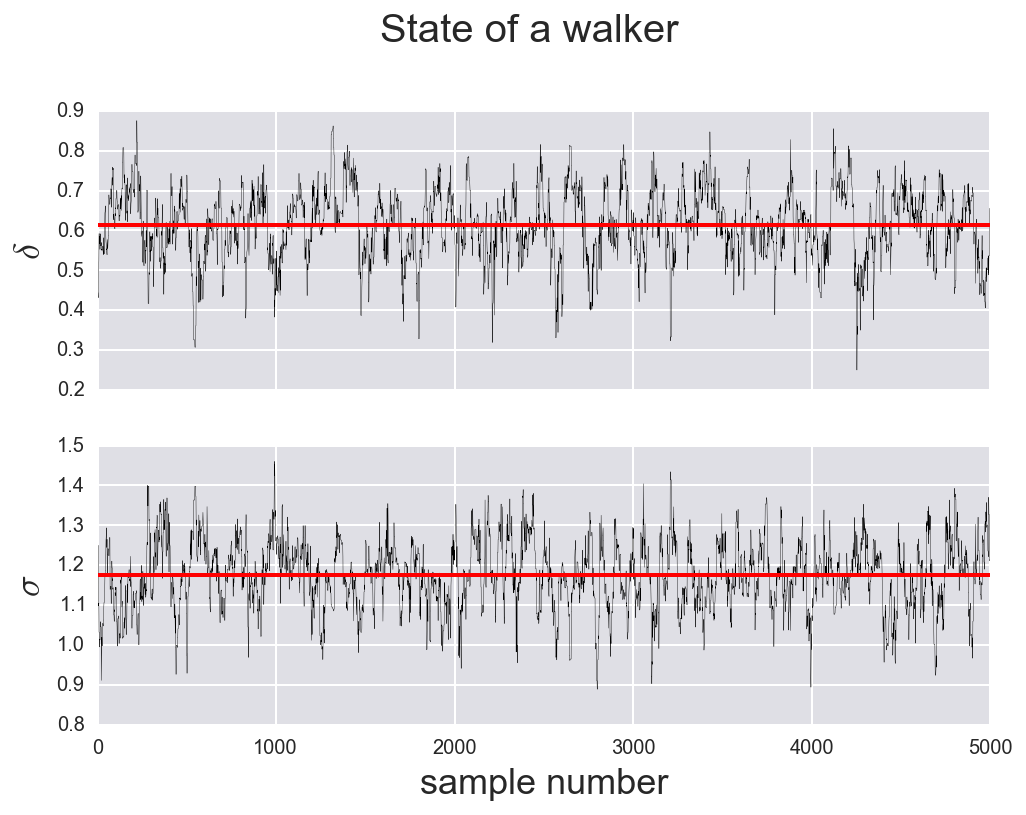

In [97]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('$\delta$')
ax[1].set_ylabel('$\sigma$')
fig.text(0.5,1, "State of a walker", ha="center", va="center", fontsize=20)

Since the question asks us to calculate the probability distribution, we go ahead and plot the marginalized posteriors.

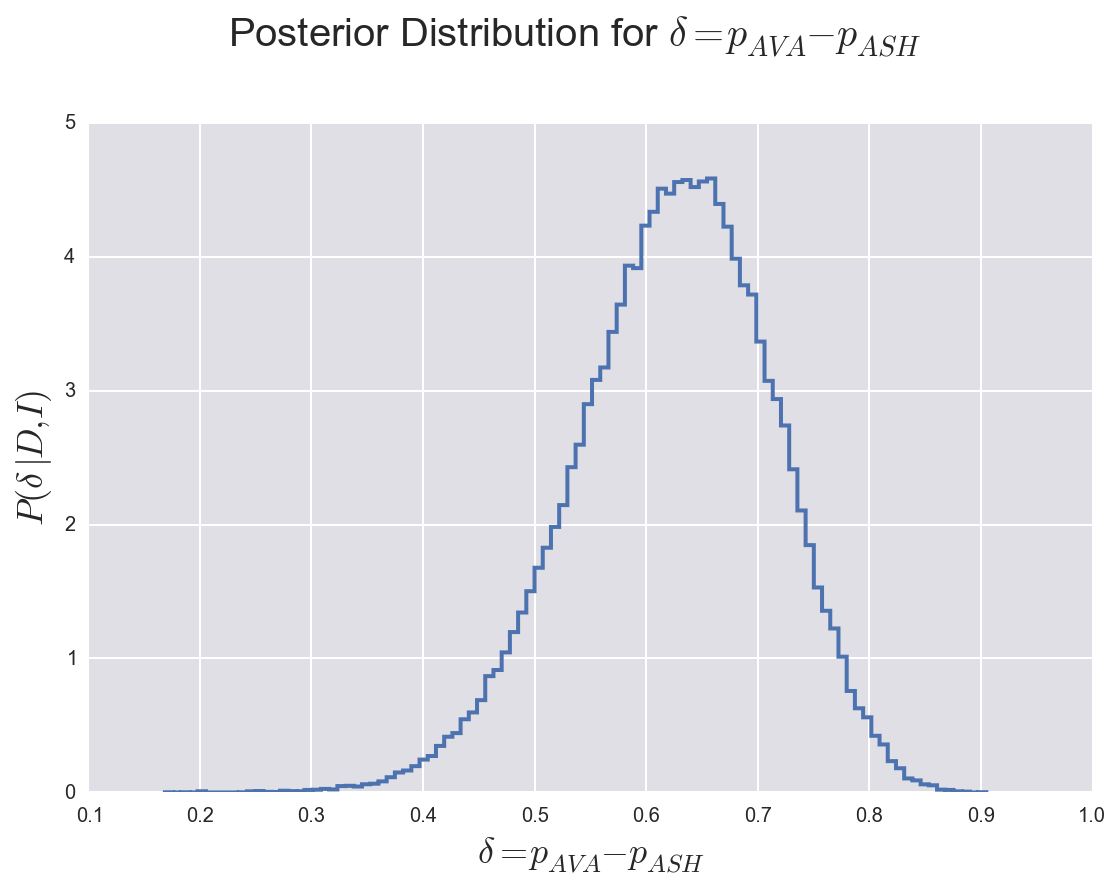

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
#for i in [0, 1]:
    # Plot the histogram as a step plot
_ = ax.hist(sampler.flatchain[:,0], bins=100, normed=True, 
                   histtype='step', lw=2)

ax.set_xlabel('$\delta=p_{AVA}-p_{ASH}$')
#ax[1].set_xlabel('$\sigma$')
ax.set_ylabel('$P(\delta \mid D,I)$')

fig.text(0.5,1, "Posterior Distribution for $\delta=p_{AVA}-p_{ASH}$", ha="center", va="center", fontsize=20)

When compared to the posterior distribution that was obtained after calculating the "gnarly" integrals, the posterior distribution for $\delta$ is very similar.

# Part b.

Read the dataframe, and tidy it. Extract datapoints that we will be looking at in the question, and store it in `WtVenus`.

In [4]:
df2 = pd.read_csv('data/reeves_gradient_width_various_methods.csv', comment='#', header=[0,1])
TidyData2 = pd.melt(df2)
TidyData2.columns = ['Genotype', 'VisualizationMethod', 'GradientWidth']
TidyData2 = TidyData2.dropna().reset_index(drop=True)

# Create new DataFrame with only the samples of interest
inds = (TidyData2.Genotype=='wt') & (TidyData2.VisualizationMethod=='cross-sections')
inds2 = (TidyData2.Genotype=='dl1/+; dl-venus/+') & (TidyData2.VisualizationMethod=='anti-Dorsal')
WtVenus = pd.concat((TidyData2[inds], TidyData2[inds2]))


We are looking at the difference in the gradient widths between the two genotypes (wild type measured via cross-sections and anti-Dorsal staining in the dl1/+ ; dl-venus / + ), which can be expressed as the difference of the mean Gradient width for wildtype ($\sigma_{wt}$) and Venus ($\sigma_{venus}$). 

We define separate posterior distributions for the Venus and wildtype, based on the fact that they are independent of each other and thus can be sampled separately using MCMC. We assume that the two variables, i.e., Gradient width from the WT-crosssection group, and Gradient width from the *venus* group are Gaussian distributed (Central limit theorem). 

Hence, our likelihood functions were defined as:

\begin{align}
P(D \mid \mu_{venus},\sigma_{venus},I) = \frac{1}{\sqrt{2\pi\sigma_{venus}^2}}\,\exp\left[-\frac{1}{2\,\sigma_{venus}^2 } \sum_{i\in D} [x_i-\mu_{venus}]^2\right] 
\end{align}

\begin{align}
P(D \mid \mu_{wt},\sigma_{wt},I) = \frac{1}{\sqrt{2\pi\sigma_{wt}^2}}\,\exp\left[-\frac{1}{2\,\sigma_{wt}^2 } \sum_{i\in D} [x_i-\mu_{wt}]^2\right] 
\end{align}

We used a uniform prior for $\mu$, and a Jeffrey's prior for $\sigma$. Hence, our posterior distributions are given by: 

\begin{align}
P(\mu_{venus},\sigma_{venus} \mid D ,I) \propto \frac{1}{\sigma_{venus}^{n+1}}\,\exp\left[-\frac{1}{2\,\sigma_{venus}^2 } \sum_{i\in D} [x_i-\mu_{venus}]^2\right] 
\end{align}

\begin{align}
P(\mu_{wt},\sigma_{wt} \mid D ,I) \propto \frac{1}{\sigma_{wt}^{n+1}}\,\exp\left[-\frac{1}{2\,\sigma_{wt}^2 } \sum_{i\in D} [x_i-\mu_{wt}]^2\right] 
\end{align}

We use these posterior distributions to define our log posterior function.

In [ ]:
def LogPosterior(p, d):
    """
    Log posterior for wild type data
    """
    #unpack parameters
    mu, sigma = p
    
    #return -inf for out of bound values
    if (mu < 0) or (sigma < 0):
        return -np.inf
    
    #return log of posterior as defined in the previous cell
    return -(len(d) + 1) * np.log(sigma) - (1/ (2*sigma**2)) * np.sum((d - mu)**2) 

Lets start by defining the parameters for the MCMC calculations. We are trying to estimate $\mu$ and $\sigma$, so the number of parameters in the model is 2. All other specifications have been adopted from the tutorial on MCMC.

In [10]:
n_dim = 2        # number of parameters in the model (mu and sigma)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

#define different arguments for WT and venus data 

argsWT=(WtVenus.GradientWidth[WtVenus.Genotype=="wt"],)
argsVenus=(WtVenus.GradientWidth[WtVenus.Genotype=="dl1/+; dl-venus/+"],)

The only restriction on $\mu$ and $\sigma$ is that they must be positive values, so we will draw their starting points out of an exponential distribution with mean of 1. 

In [11]:
p0 = np.empty((n_walkers, n_dim))

p0[:,0] = np.random.exponential(0.1, n_walkers)     # mu
p0[:,1] = np.random.exponential( 0.1, n_walkers)   #sigma

Perform MCMC for wild-type gradient width data.

In [12]:
samplerWT = emcee.EnsembleSampler(n_walkers, n_dim, LogPosterior, args=argsWT)

In [13]:
pos, prob, state = samplerWT.run_mcmc(p0, n_burn, storechain=False)

In [14]:
_ = samplerWT.run_mcmc(pos, n_steps)

Plot the results.

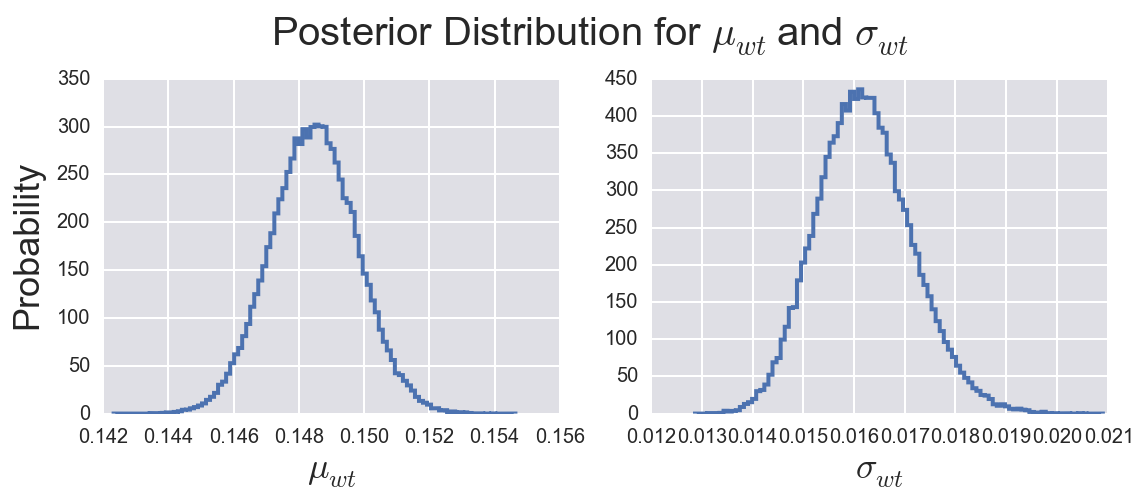

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(samplerWT.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel('$\mu_{wt}$')
ax[1].set_xlabel('$\sigma_{wt}$')
ax[0].set_ylabel('Probability')
fig.text(0.5,1, "Posterior Distribution for $\mu_{wt}$ and $\sigma_{wt}$", ha="center", va="center", fontsize=20)

Perform MCMC for Venus data.

In [16]:
samplerVenus = emcee.EnsembleSampler(n_walkers, n_dim, LogPosterior, args=argsVenus)

In [17]:
pos, prob, state = samplerVenus.run_mcmc(p0, n_burn, storechain=False)

In [18]:
_ = samplerVenus.run_mcmc(pos, n_steps)

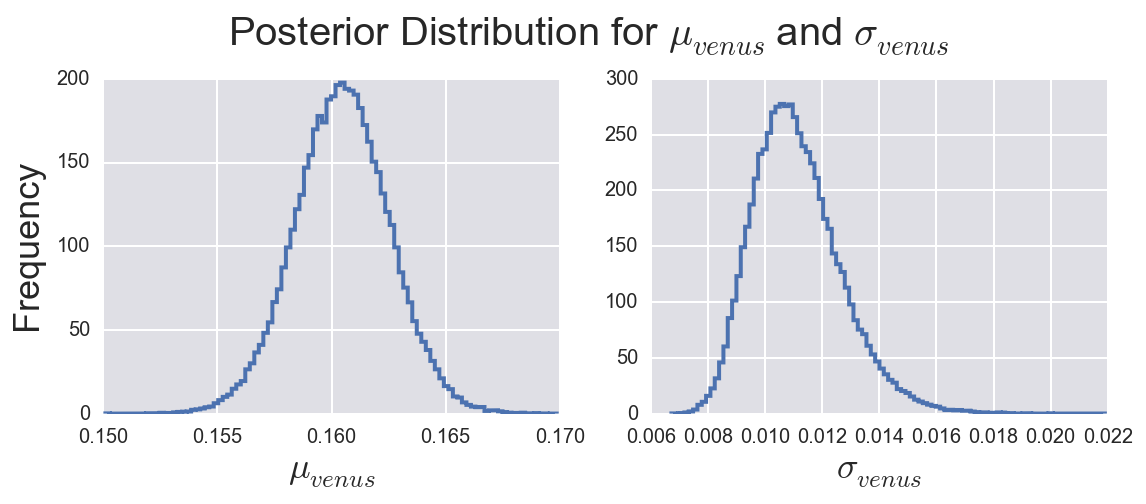

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(samplerVenus.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel('$\mu_{venus}$')
ax[1].set_xlabel('$\sigma_{venus}$')
ax[0].set_ylabel('Probability')
fig.text(0.5,1, "Posterior Distribution for $\mu_{venus}$ and $\sigma_{venus}$", ha="center", va="center", fontsize=20)

Now in order to calculate the posterior distribution for $\delta \equiv \sigma_{venus}-\sigma_{wt}$, the difference of the two samples (wild type measured via cross-sections and anti-Dorsal staining in the dl1/+ ; dl-venus / + ), we find the difference of the posterior distributions for $\mu_{venus}$ and $\mu_{wt}$.

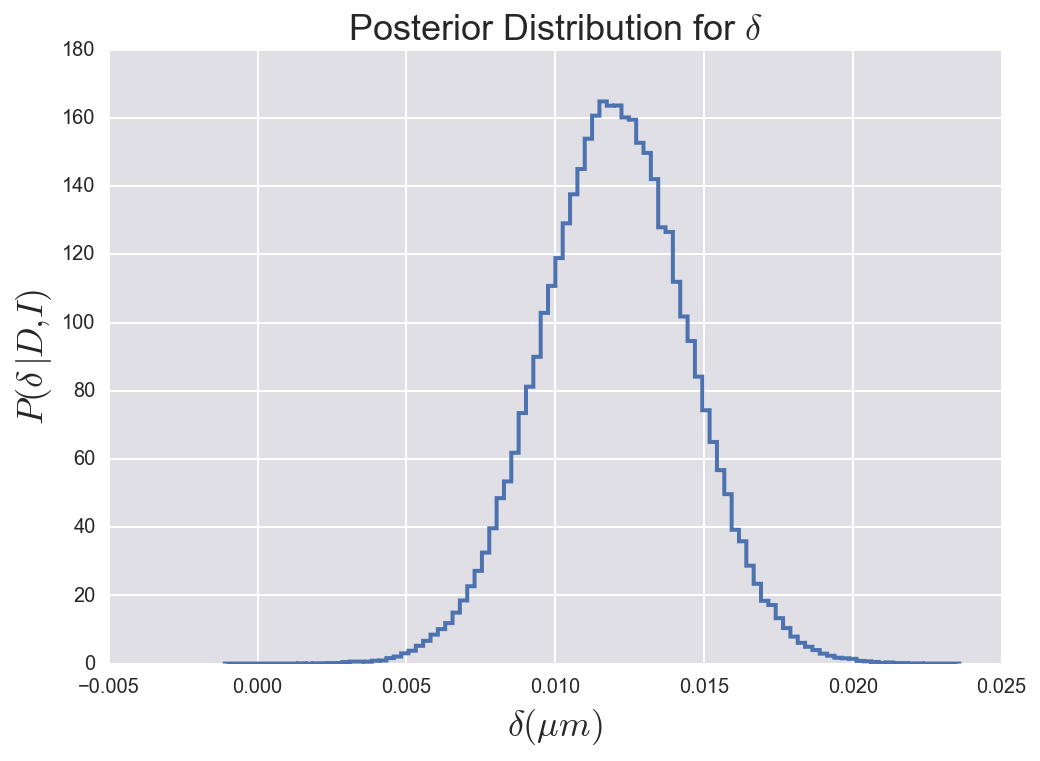

In [104]:
MeanDifference = samplerVenus.flatchain[:,0] - samplerWT.flatchain[:,0]

#if you want to find sigma, you can do that using the command:
#JointSigma = np.sqrt( samplerVenus.flatchain[:,1]**2 - samplerWT.flatchain[:,1]**2 )

#plot the posterior distribution
_ = plt.hist(MeanDifference, bins=100, normed=True,histtype='step', lw=2)
plt.title("Posterior Distribution for $\delta$")
plt.ylabel("$P(\delta \mid D,I)$")
plt.xlabel("$\delta(\mu m)$")

In order to make comparisons with the posterior distributions of the individual samples, lets plot all three on the same graph.

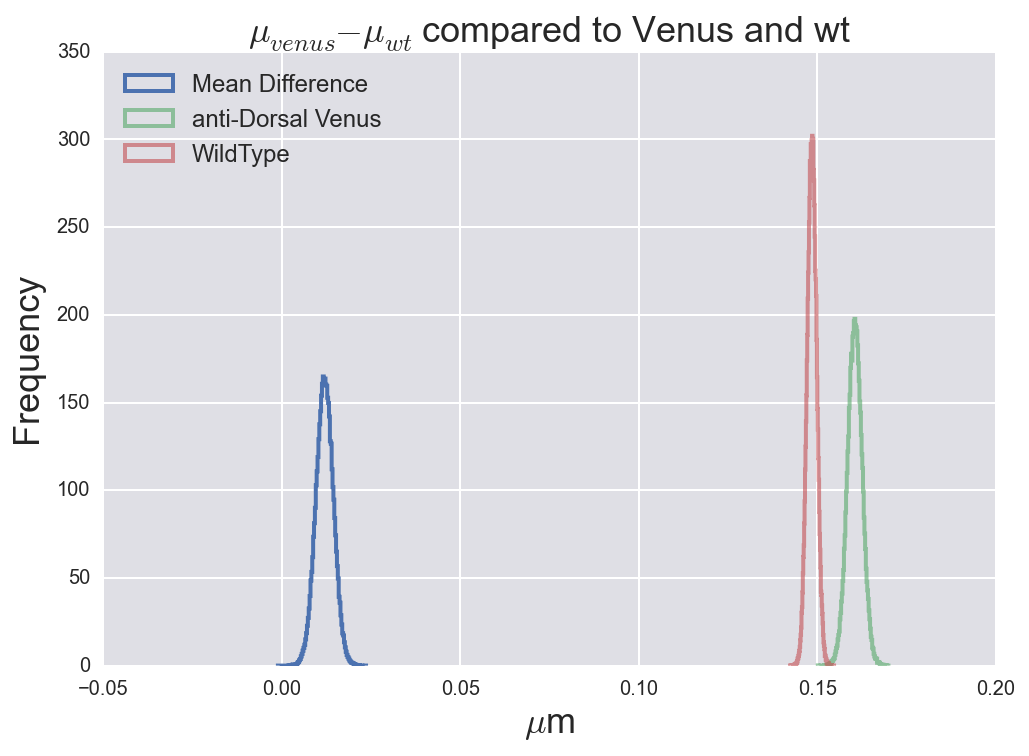

In [67]:
_ = plt.hist(MeanDifference, bins=100, normed=True,histtype='step', lw=2)
_ = plt.hist(samplerVenus.flatchain[:,0], bins=100, normed=True, histtype='step', lw=2, alpha=0.6)
_ = plt.hist(samplerWT.flatchain[:,0], bins=100, normed=True, histtype='step', lw=2, alpha = 0.6)
plt.legend(labels = ["Mean Difference", "anti-Dorsal Venus", "WildType"], loc="upper left", fontsize="large")
plt.title("$\mu_{venus}-\mu_{wt}$ compared to Venus and wt")
plt.ylabel("Frequency")
plt.xlabel("$\mu$m")

To get an idea of the value at which the probability of $\delta$ is maximum:

In [40]:
#indices for wildtype
max_ind1 = np.argmax( samplerWT.flatlnprobability)
#indices for venus
max_ind2 = np.argmax( samplerVenus.flatlnprobability)

In [41]:
#parse results from sampler instance
MAPmuWT, MAPsigmaWT = samplerWT.flatchain[max_ind1,:]
MAPmuVenus, MAPsigmaVenus = samplerVenus.flatchain[max_ind2, :] 

In [42]:
#calculate difference
MAPmuVenus - MAPmuWT

0.012030333282456757

Hence, the most probable value for $\delta$ is 0.012.